In the Data folder file I showed that t>20 basically corresponds to noise. Here I want to check if the network performance improves if I throw out this noise.

In [1]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

MASKS = np.load('../data/masks.npy')

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

# ***Possoin undersampling***

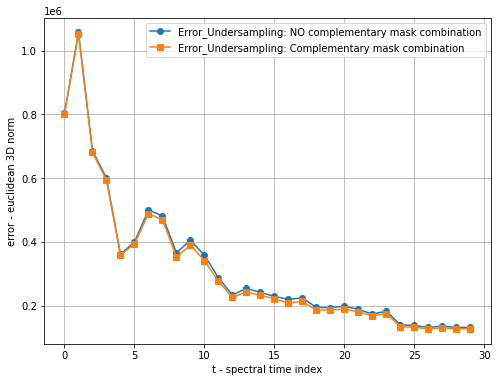

In [2]:
Dataset = 'LowRank' # Options: FullRank, SpectralFit, LowRank
trancuate_t = 30
Patient = 0
AF = 5

if Dataset == 'FullRank':
    Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
    Undersampled_Data_SC = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_possoin_3D_fixed_r0_AF_{AF}_Single_Combination.npy')
elif Dataset == 'SpectralFit':
    Ground_Truth = np.load('../data/P04_And_P08_Spectral_Fit.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P04AndP08_SpectralFit/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
    Undersampled_Data_SC = np.load(f'../data/Undersampled_Data_P04AndP08_SpectralFit/Undersampled_possoin_3D_fixed_r0_AF_{AF}_Single_Combination.npy')
elif Dataset == 'LowRank':
    Ground_Truth = np.load('../data/Low_Rank_8_P03-P08.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08_LowRank/Undersampled_possoin_3D_fixed_r0_AF_{AF}.npy')
    Undersampled_Data_SC = np.load(f'../data/Undersampled_Data_P03-P08_LowRank/Undersampled_possoin_3D_fixed_r0_AF_{AF}_Single_Combination.npy')
else:
    print('Choose valid option for Dataset: FullRank, SpectralFit, LowRank')
    
ground_truth_trancuated = Ground_Truth[:,:,:,:trancuate_t,:,:]
Undersampled_Data_trancuated = Undersampled_Data[:,:,:,:trancuate_t,:,:]
Undersampled_Data_SC_trancuated = Undersampled_Data_SC[:,:,:,:trancuate_t,:,:]
    
Error_Undersampling = np.abs(ground_truth_trancuated-Undersampled_Data_trancuated)[..., Patient]
Error_Undersampling_SC = np.abs(ground_truth_trancuated-Undersampled_Data_SC_trancuated)[..., Patient]

#### Compute 2 Norm
Error_Undersampling_norm = np.sqrt(np.sum(Error_Undersampling**2, axis=(0, 1, 2))) ## compute 3D norm
Error_Undersampling_SC_norm = np.sqrt(np.sum(Error_Undersampling_SC**2, axis=(0, 1, 2)))

#### Average over T
Error_Undersampling_norm = np.mean(Error_Undersampling_norm, axis=1)
Error_Undersampling_SC_norm = np.mean(Error_Undersampling_SC_norm, axis=1)

#### PLOT!!!

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the two lists; you can add markers if desired.
plt.plot(Error_Undersampling_norm, label="Error_Undersampling: NO complementary mask combination", marker='o')
plt.plot(Error_Undersampling_SC_norm, label="Error_Undersampling: Complementary mask combination", marker='s')

# Add labels and title
plt.xlabel("t - spectral time index")
plt.ylabel("error - euclidean 3D norm")

# Add a legend to indicate which line corresponds to which list.
plt.legend()

# Optionally, add a grid for easier visualization.
plt.grid(True)

# ***Regular Undersampling***

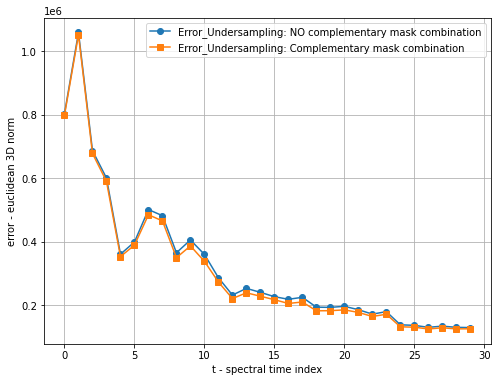

In [5]:
Dataset = 'LowRank' # Options: FullRank, SpectralFit, LowRank
trancuate_t = 30
Patient = 0

if Dataset == 'FullRank':
    Ground_Truth = np.load('../data/Full_Rank_All_trancuated_k_space_masked.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_Regular.npy')
    Undersampled_Data_SC = np.load(f'../data/Undersampled_Data_P03-P08/Undersampled_Regular_Single_Combination.npy')
elif Dataset == 'SpectralFit':
    Ground_Truth = np.load('../data/P04_And_P08_Spectral_Fit.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P04AndP08_SpectralFit/Undersampled_Regular.npy')
    Undersampled_Data_SC = np.load(f'../data/Undersampled_Data_P04AndP08_SpectralFit/Undersampled_Regular_Single_Combination.npy')
elif Dataset == 'LowRank':
    Ground_Truth = np.load('../data/Low_Rank_8_P03-P08.npy')
    Undersampled_Data = np.load(f'../data/Undersampled_Data_P03-P08_LowRank/Undersampled_Regular.npy')
    Undersampled_Data_SC = np.load(f'../data/Undersampled_Data_P03-P08_LowRank/Undersampled_Regular_Single_Combination.npy')
else:
    print('Choose valid option for Dataset: FullRank, SpectralFit, LowRank')
    
ground_truth_trancuated = Ground_Truth[:,:,:,:trancuate_t,:,:]
Undersampled_Data_trancuated = Undersampled_Data[:,:,:,:trancuate_t,:,:]
Undersampled_Data_SC_trancuated = Undersampled_Data_SC[:,:,:,:trancuate_t,:,:]
    
Error_Undersampling = np.abs(ground_truth_trancuated-Undersampled_Data_trancuated)[..., Patient]
Error_Undersampling_SC = np.abs(ground_truth_trancuated-Undersampled_Data_SC_trancuated)[..., Patient]

#### Compute 2 Norm
Error_Undersampling_norm = np.sqrt(np.sum(Error_Undersampling**2, axis=(0, 1, 2))) ## compute 3D norm
Error_Undersampling_SC_norm = np.sqrt(np.sum(Error_Undersampling_SC**2, axis=(0, 1, 2)))

#### Average over T
Error_Undersampling_norm = np.mean(Error_Undersampling_norm, axis=1)
Error_Undersampling_SC_norm = np.mean(Error_Undersampling_SC_norm, axis=1)

#### PLOT!!!

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the two lists; you can add markers if desired.
plt.plot(Error_Undersampling_norm, label="Error_Undersampling: NO complementary mask combination", marker='o')
plt.plot(Error_Undersampling_SC_norm, label="Error_Undersampling: Complementary mask combination", marker='s')

# Add labels and title
plt.xlabel("t - spectral time index")
plt.ylabel("error - euclidean 3D norm")

# Add a legend to indicate which line corresponds to which list.
plt.legend()

# Optionally, add a grid for easier visualization.
plt.grid(True)


# ***Compare ground truth to undersampled***

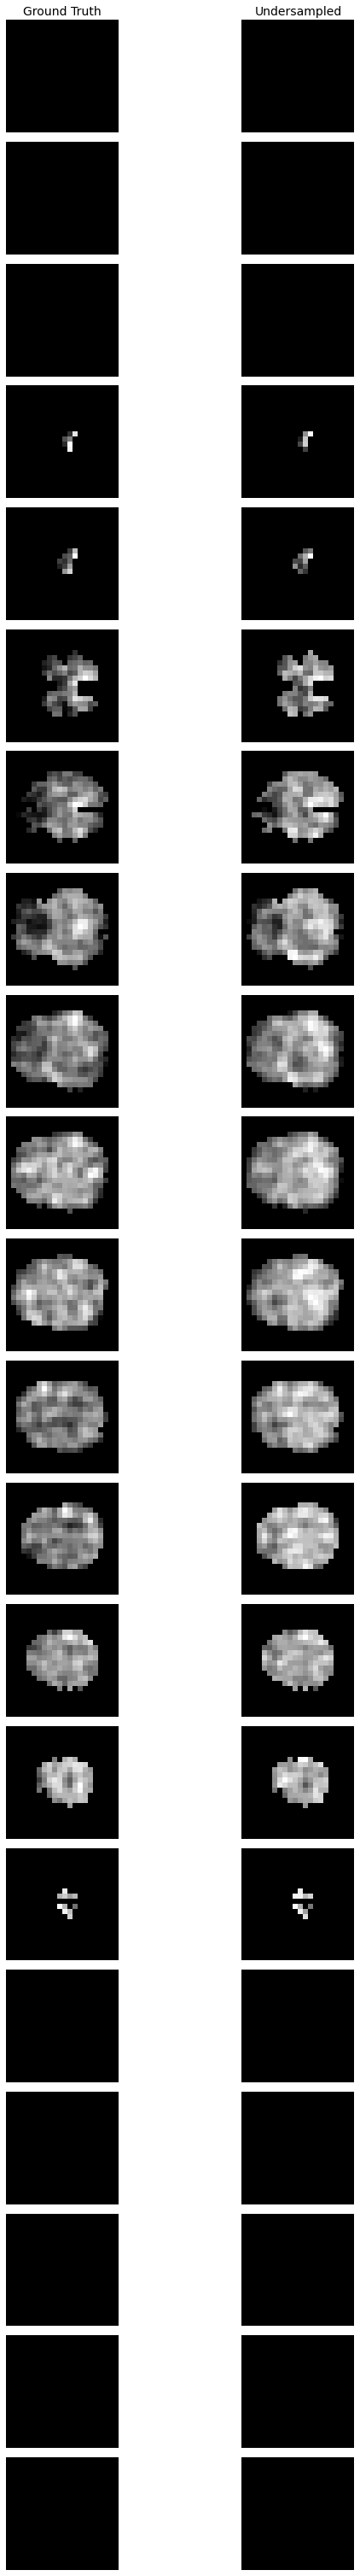

In [4]:
# Example indices (adjust as needed)
t = 10
T = 5
Patient = 0

# Extract the absolute values from the ground truth and undersampled data
# (Assuming your arrays have at least 6 dimensions as shown)
ground_truth_trancuated_abs = np.abs(ground_truth_trancuated)[:, :, :, t, T, Patient]
Undersampled_Data_trancuated_abs = np.abs(Undersampled_Data_trancuated)[:, :, :, t, T, Patient]

# Create a figure with 21 rows and 2 columns.
# Increase the overall figure size to give each subplot more room.
fig, axes = plt.subplots(21, 2, figsize=(10, 42))

# Add column titles to the top row of subplots.
axes[0, 0].set_title('Ground Truth', fontsize=14)
axes[0, 1].set_title('Undersampled', fontsize=14)

# Loop over the 21 slices and display each in its corresponding subplot.
for i in range(21):
    # Left column: Ground Truth image
    axes[i, 0].imshow(ground_truth_trancuated_abs[:, :, i], cmap='gray')
    axes[i, 0].axis('off')
    
    # Right column: Undersampled image
    axes[i, 1].imshow(Undersampled_Data_trancuated_abs[:, :, i], cmap='gray')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()